In [770]:
import numpy as np
from scipy.integrate import odeint
import importlib.util
import scipy.stats
import matplotlib.pyplot as plt
import copy
import sys
import os
from sklearn.linear_model import LinearRegression

file_path_ekf = '/home/austin/Drone_AFRL/ekf.py'
EKF_Module = 'ekf'
# Load the EKF module
spec_ekf = importlib.util.spec_from_file_location(EKF_Module, file_path_ekf)
EKF = importlib.util.module_from_spec(spec_ekf)
sys.modules[EKF_Module] = EKF
spec_ekf.loader.exec_module(EKF)

ekf.py loaded successfully


# <center> Uploading real drone data <center>

In [651]:
# load all files in the directory /CSV into data frames with names corresponding to the file names remove "test_bag__slash" from the start of the name
import glob
import pandas as pd

# Load the data
sub_path = 'neg_X/'
path = '/home/austin/Drone_AFRL/CSV/'+ sub_path
all_files = glob.glob(path + "/*.csv")
data = {}

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    data[os.path.basename(filename)[len(sub_path)+7:-4]] = df

data = {key.replace("_slash_", "/"): value for key, value in data.items()}

for key in data.keys():
    print(key)

optic_flow/camera/mean/x
trisonica_global
mavros/imu/data
drone/rpy/degrees
mavros/rc/in
optic_flow
optic_flow/camera/mean/y
mavros/local_position/pose
drone/rpy/radians
optic_flow/wind_sensor/mean/y
optic_flow/global/mean/x
mavros/rc/out
trisonica_body_level
optic_flow/wind_sensor/mean/x
trisonica
optic_flow/global/mean/y


# <center> Ground Truth (Mocap) <center>

In [652]:
data['mavros/local_position/pose']

,rosbagTimestamp,header,seq,stamp,secs,nsecs,frame_id,pose,position,x,y,z,orientation,x.1,y.1,z.1,w
0,1726109483478350322,NaN,10947,NaN,1722536971,535796352,"""map""",NaN,NaN,-0.652569,-0.065167,0.263797,NaN,-0.018975,-0.025734,0.775479,-0.630563
1,1726109483504783016,NaN,10948,NaN,1722536971,556796352,"""map""",NaN,NaN,-0.653235,-0.067521,0.269789,NaN,-0.016044,-0.025491,0.776270,-0.629680
2,1726109483537233460,NaN,10949,NaN,1722536971,588796352,"""map""",NaN,NaN,-0.653975,-0.070847,0.279517,NaN,-0.014354,-0.017971,0.777786,-0.628108
3,1726109483570342591,NaN,10950,NaN,1722536971,630795328,"""map""",NaN,NaN,-0.654530,-0.075028,0.293698,NaN,-0.013301,-0.012181,0.779157,-0.626569
4,1726109483605488048,NaN,10951,NaN,1722536971,662795328,"""map""",NaN,NaN,-0.654661,-0.077822,0.305181,NaN,-0.012499,-0.010573,0.779659,-0.625991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1366,1726109529002994174,NaN,12313,NaN,1722537017,61377280,"""map""",NaN,NaN,-2.240180,-0.407701,1.711027,NaN,-0.001871,-0.055046,0.778569,-0.625138
1367,1726109529041504447,NaN,12314,NaN,1722537017,93377280,"""map""",NaN,NaN,-2.236877,-0.405932,1.707903,NaN,-0.008477,-0.053814,0.777660,-0.626321
1368,1726109529071718442,NaN,12315,NaN,1722537017,125377536,"""map""",NaN,NaN,-2.232738,-0.404392,1.704727,NaN,-0.013575,-0.050824,0.777174,-0.627083
1369,1726109529104276123,NaN,12316,NaN,1722537017,157377536,"""map""",NaN,NaN,-2.227789,-0.403028,1.701617,NaN,-0.013996,-0.049630,0.777365,-0.626933


In [653]:


# function ro convert from quaternion to euler angles
def quaternion_to_euler(x, y, z, w):
    import math
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    R = math.degrees(math.atan2(t0, t1))

    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    P = math.degrees(math.asin(t2))

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    Y = math.degrees(math.atan2(t3, t4))

    return R, P, Y

# function that interpolates data based on two time arrays using numpy
def interpolate_data(time1, data1, time2):
    """
    input: time1 (interp from), data1 (interp from), time2 (interp to)
    output: interpolated data2
    """
    return np.interp(time2, time1, data1)

# function that takes in data frame and gives out time array based on the columns secs and nsecs
def time_array(data):
    "input: data frame with columns secs and nsecs"
    "output: array of time in seconds"
    time = []
    for i in range(len(data)):
        time.append(data['secs'][i] + data['nsecs'][i] * 1e-9)

    return time

# mocap_time = time_array(data['mavros/local_position/pose'])
mocap_time = data['mavros/local_position/pose']['rosbagTimestamp']/1e9
mocap_Roll, mocap_Pitch, mocap_Yaw = [], [], []
for i in range(len(data['mavros/local_position/pose'])):
    R, P, Y = quaternion_to_euler(data['mavros/local_position/pose']['x.1'][i],
                                  data['mavros/local_position/pose']['y.1'][i],
                                  data['mavros/local_position/pose']['z.1'][i],
                                  data['mavros/local_position/pose']['w'][i])
    mocap_Roll.append(R)
    mocap_Pitch.append(P)
    mocap_Yaw.append(Y)

mocap_X = data['mavros/local_position/pose']['x']
mocap_Y = data['mavros/local_position/pose']['y']
mocap_Z = data['mavros/local_position/pose']['z']

mocap_time_shifted = mocap_time - mocap_time[0]

# take the derivative of the mocap data to get the velocities
mocap_X_dot = np.gradient(mocap_X, mocap_time)
mocap_Y_dot = np.gradient(mocap_Y, mocap_time)
mocap_Z_dot = np.gradient(mocap_Z, mocap_time)

# take the derivative of the mocap data to get the accelerations
mocap_X_ddot = np.gradient(mocap_X_dot, mocap_time)
mocap_Y_ddot = np.gradient(mocap_Y_dot, mocap_time)
mocap_Z_ddot = np.gradient(mocap_Z_dot, mocap_time)


Mocap data time length: 1371
Mocap data Roll length: 1371
Mocap data Pitch length: 1371
Mocap data Yaw length: 1371


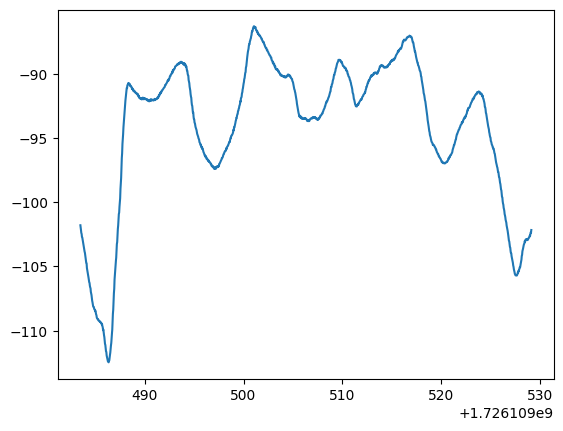

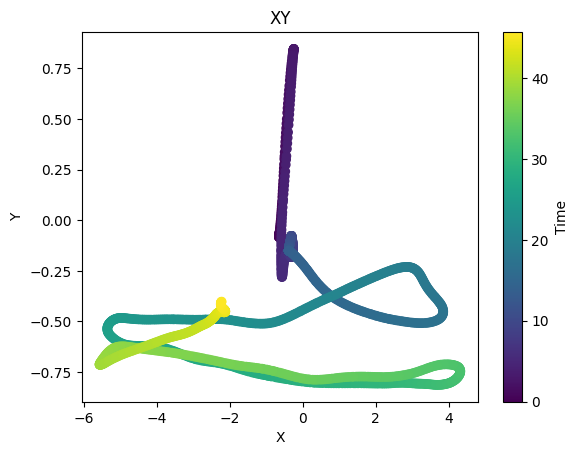

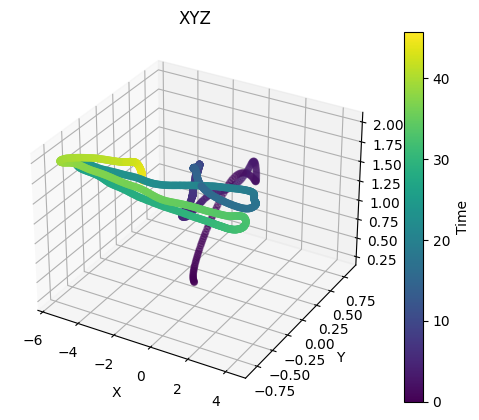

In [654]:
print('Mocap data time length:', len(mocap_time))
print('Mocap data Roll length:', len(mocap_Roll))
print('Mocap data Pitch length:', len(mocap_Pitch))
print('Mocap data Yaw length:', len(mocap_Yaw))

plt.plot(mocap_time, mocap_Yaw)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# make plot of XY and 2d plot of XY with time as color
plt.figure()
plt.scatter(mocap_X, mocap_Y, c=mocap_time_shifted)
plt.title('XY')
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar(label='Time')
plt.show()

# make 3d plot of XYZ with time as color
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(mocap_X, mocap_Y, mocap_Z, c=mocap_time_shifted)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('XYZ')
plt.colorbar(sc, label='Time')
plt.show()


# <center> IMU (Roll,Pitch,Yaw) + (Roll_dot,Pitch_dot,Yaw_dot) + (X_acc,Y_acc,Z_acc)

In [655]:
data['mavros/imu/data']
# print columns of the imu data
for col in data['mavros/imu/data'].columns:
    print(col)

rosbagTimestamp
header
seq
stamp
secs
nsecs
frame_id
orientation
x
y
z
w
orientation_covariance
angular_velocity
x.1
y.1
z.1
angular_velocity_covariance
linear_acceleration
x.2
y.2
z.2
linear_acceleration_covariance


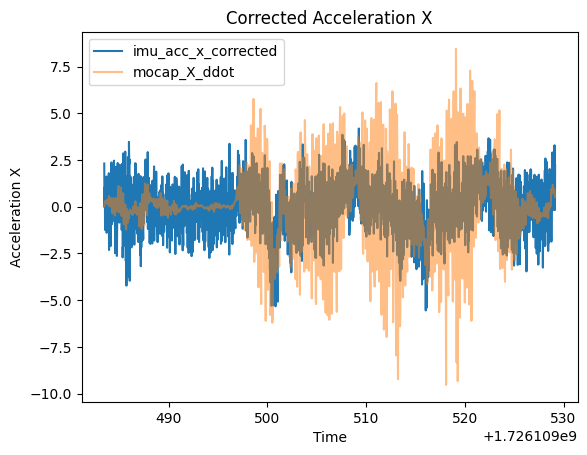

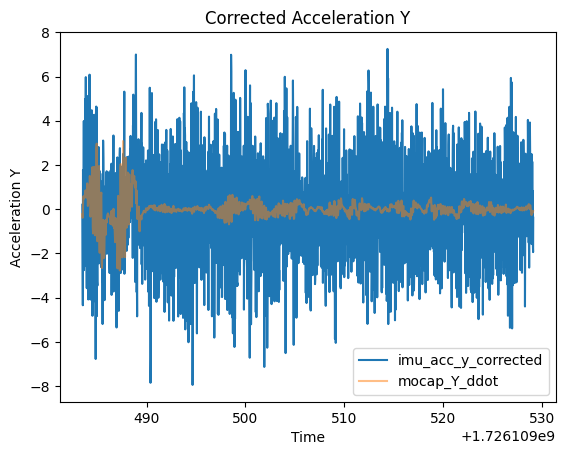

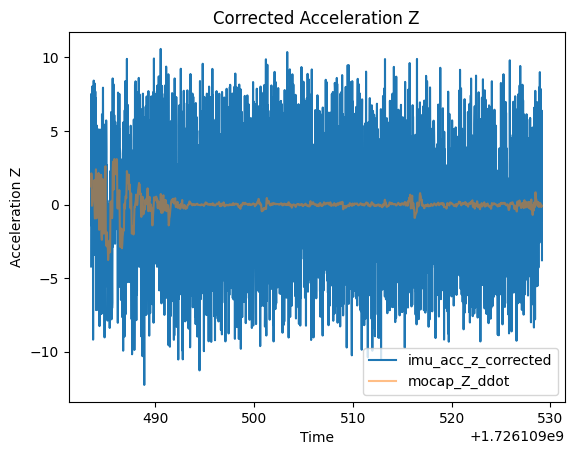

In [656]:
imu_time = data['mavros/imu/data']['rosbagTimestamp']/1e9
imu_time_shifted = imu_time - imu_time[0]
imu_Roll, imu_Pitch, imu_Yaw = [], [], []
for i in range(len(data['mavros/imu/data'])):
    R, P, Y = quaternion_to_euler(data['mavros/imu/data']['x'][i],
                                  data['mavros/imu/data']['y'][i],
                                  data['mavros/imu/data']['z'][i],
                                  data['mavros/imu/data']['w'][i])
    imu_Roll.append(np.radians(R))
    imu_Pitch.append(np.radians(P))
    imu_Yaw.append(np.radians(Y))

imu_Roll_rate = data['mavros/imu/data']['x.1']
imu_Pitch_rate = data['mavros/imu/data']['y.1']
imu_Yaw_rate = data['mavros/imu/data']['z.1']

g = 9.81  # Gravitational acceleration (m/s^2)

# Function to compute the rotation matrix from roll, pitch, yaw
def rotation_matrix_from_euler(roll, pitch, yaw):
    """
    Creates a rotation matrix from roll, pitch, yaw angles (in radians).
    """
    # Compute rotation matrices for roll, pitch, and yaw
    R_roll = np.array([
        [1, 0, 0],
        [0, np.cos(roll), -np.sin(roll)],
        [0, np.sin(roll), np.cos(roll)]
    ])
    
    R_pitch = np.array([
        [np.cos(pitch), 0, np.sin(pitch)],
        [0, 1, 0],
        [-np.sin(pitch), 0, np.cos(pitch)]
    ])
    
    R_yaw = np.array([
        [np.cos(yaw), -np.sin(yaw), 0],
        [np.sin(yaw), np.cos(yaw), 0],
        [0, 0, 1]
    ])
    
    # Combine the rotation matrices (Z * Y * X)
    R = R_yaw @ R_pitch @ R_roll
    return R

# Function to remove gravity from linear acceleration
def remove_gravity_from_acceleration(acc_x, acc_y, acc_z, roll, pitch, yaw):
    """
    Removes the gravity component from the linear acceleration in the body frame.
    
    acc_x, acc_y, acc_z: numpy arrays
        Arrays of linear acceleration in the body frame along the x, y, and z axes.
    roll, pitch, yaw: numpy arrays
        Arrays of roll, pitch, and yaw angles (in radians).
    
    Returns:
    acc_x_corrected, acc_y_corrected, acc_z_corrected: numpy arrays
        Corrected linear accelerations with gravity removed along the x, y, and z axes.
    """
    # Initialize corrected acceleration arrays
    acc_x_corrected = np.zeros_like(acc_x)
    acc_y_corrected = np.zeros_like(acc_y)
    acc_z_corrected = np.zeros_like(acc_z)
    
    # Gravity vector in the world frame (assume gravity points along the Z-axis)
    gravity_world = np.array([0, 0, g])
    
    # Loop over each time step and correct the acceleration
    for i in range(len(acc_x)):
        # Get the rotation matrix for the current orientation (roll, pitch, yaw)
        R = rotation_matrix_from_euler(roll[i], pitch[i], yaw[i])
        
        # Transform gravity vector from world frame to body frame
        gravity_body = R.T @ gravity_world  # Transpose R to rotate from world to body
        
        # Measured acceleration in body frame
        acc_body = np.array([acc_x[i], acc_y[i], acc_z[i]])
        
        # Subtract gravity from the body-frame acceleration
        acc_corrected = acc_body - gravity_body
        
        # Store the corrected acceleration
        acc_x_corrected[i] = acc_corrected[0]
        acc_y_corrected[i] = acc_corrected[1]
        acc_z_corrected[i] = acc_corrected[2]
    
    return acc_x_corrected, acc_y_corrected, acc_z_corrected

# Remove gravity from the linear acceleration
imu_acc_x_corrected, imu_acc_y_corrected, imu_acc_z_corrected = remove_gravity_from_acceleration(
    data['mavros/imu/data']['x.2'],
    data['mavros/imu/data']['y.2'],
    data['mavros/imu/data']['z.2'],
    imu_Roll, imu_Pitch, imu_Yaw
)

# rotate the acceleration data to the world frame
def rotate_acceleration_to_world_frame(acc_x, acc_y, acc_z, roll, pitch, yaw):
    """
    Rotates the linear acceleration from the body frame to the world frame.
    
    acc_x, acc_y, acc_z: numpy arrays
        Arrays of linear acceleration in the body frame along the x, y, and z axes.
    roll, pitch, yaw: numpy arrays
        Arrays of roll, pitch, and yaw angles (in radians).
    
    Returns:
    acc_x_world, acc_y_world, acc_z_world: numpy arrays
        Linear acceleration in the world frame along the x, y, and z axes.
    """
    # Initialize world-frame acceleration arrays
    acc_x_world = np.zeros_like(acc_x)
    acc_y_world = np.zeros_like(acc_y)
    acc_z_world = np.zeros_like(acc_z)
    
    # Loop over each time step and rotate the acceleration
    for i in range(len(acc_x)):
        # Get the rotation matrix for the current orientation (roll, pitch, yaw)
        R = rotation_matrix_from_euler(roll[i], pitch[i], yaw[i])
        
        # Measured acceleration in body frame
        acc_body = np.array([acc_x[i], acc_y[i], acc_z[i]])
        
        # Rotate the body-frame acceleration to the world frame
        acc_world = R @ acc_body
        
        # Store the world-frame acceleration
        acc_x_world[i] = acc_world[0]
        acc_y_world[i] = acc_world[1]
        acc_z_world[i] = acc_world[2]
    
    return acc_x_world, acc_y_world, acc_z_world

# Rotate the acceleration data to the world frame
imu_acc_x_corrected_world, imu_acc_y_corrected_world, imu_acc_z_corrected_world = rotate_acceleration_to_world_frame(
    imu_acc_x_corrected, imu_acc_y_corrected, imu_acc_z_corrected, imu_Roll, imu_Pitch, imu_Yaw
)

plt.plot(imu_time, imu_acc_x_corrected_world,label='imu_acc_x_corrected')
plt.plot(mocap_time, mocap_X_ddot,label='mocap_X_ddot',alpha=0.5)
plt.title('Corrected Acceleration X')
plt.xlabel('Time')
plt.ylabel('Acceleration X')
plt.legend()
plt.show()

plt.plot(imu_time, imu_acc_y_corrected_world,label='imu_acc_y_corrected')
plt.plot(mocap_time, mocap_Y_ddot,label='mocap_Y_ddot',alpha=0.5)
plt.title('Corrected Acceleration Y')
plt.xlabel('Time')
plt.ylabel('Acceleration Y')
plt.legend()
plt.show()

plt.plot(imu_time, imu_acc_z_corrected_world,label='imu_acc_z_corrected')
plt.plot(mocap_time, mocap_Z_ddot,label='mocap_Z_ddot',alpha=0.5)
plt.title('Corrected Acceleration Z')
plt.xlabel('Time')
plt.ylabel('Acceleration Z')
plt.legend()
plt.show()








# <center> Optic Flow (Camera data) <center>

In [657]:
data['optic_flow/camera/mean/x']

,rosbagTimestamp,data
0,1726109483479515236,-245.673935
1,1726109483488925236,-214.131119
2,1726109483502891154,-142.430420
3,1726109483519644910,-91.650337
4,1726109483536876087,-38.339165
...,...,...
2715,1726109529077929805,241.898880
2716,1726109529096810292,232.082535
2717,1726109529112937123,225.968948
2718,1726109529130869532,216.031647


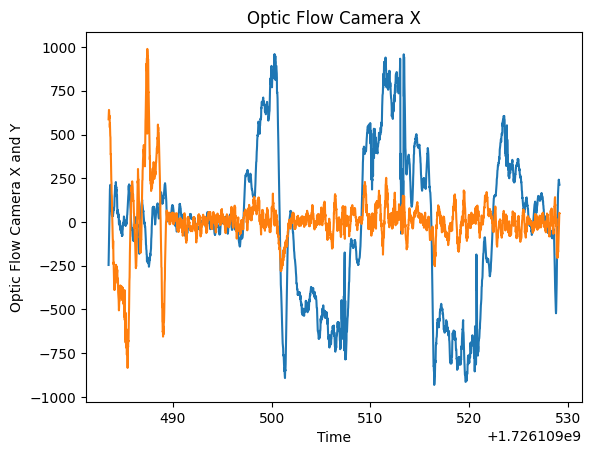

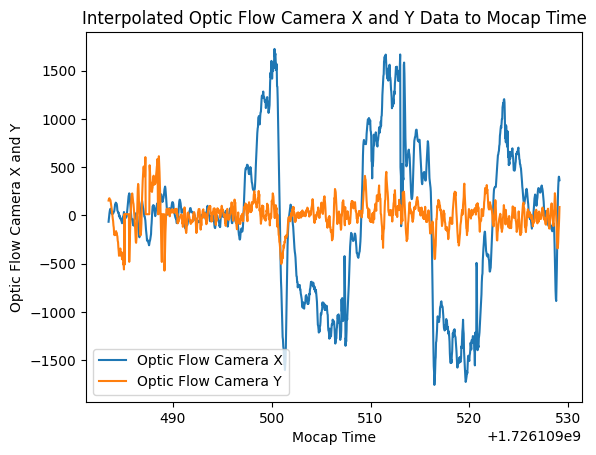

In [658]:
optic_flow_camera_x_time = data['optic_flow/camera/mean/x']['rosbagTimestamp']/1e9
optic_flow_camera_y_time = data['optic_flow/camera/mean/y']['rosbagTimestamp']/1e9
optic_flow_camera_x = data['optic_flow/camera/mean/x']['data']
optic_flow_camera_y = data['optic_flow/camera/mean/y']['data']

# print(optic_flow_camera_x_time==optic_flow_camera_y_time)

plt.plot(optic_flow_camera_x_time, optic_flow_camera_x)
plt.plot(optic_flow_camera_y_time, optic_flow_camera_y)
plt.title('Optic Flow Camera X')
plt.xlabel('Time')
plt.ylabel('Optic Flow Camera X and Y')
plt.show()



# interpolate optic flow camera data to mocap time
optic_flow_camera_x_mocap_interp = interpolate_data(optic_flow_camera_x_time, optic_flow_camera_x, mocap_time)
optic_flow_camera_y_mocap_interp = interpolate_data(optic_flow_camera_y_time, optic_flow_camera_y, mocap_time)

optic_flow_camera_x_mocap_interp=np.multiply(optic_flow_camera_x_mocap_interp, mocap_Z)
optic_flow_camera_y_mocap_interp=np.multiply(optic_flow_camera_y_mocap_interp, mocap_Z)

optic_flow_camera_x_mocap_interp[np.abs(optic_flow_camera_x_mocap_interp - np.median(optic_flow_camera_x_mocap_interp)) > 3 * np.std(optic_flow_camera_x_mocap_interp)] = np.median(optic_flow_camera_x_mocap_interp)
optic_flow_camera_y_mocap_interp[np.abs(optic_flow_camera_y_mocap_interp - np.median(optic_flow_camera_y_mocap_interp)) > 3 * np.std(optic_flow_camera_y_mocap_interp)] = np.median(optic_flow_camera_y_mocap_interp)



# Plot the interpolated data
plt.plot(mocap_time, optic_flow_camera_x_mocap_interp, label="Optic Flow Camera X")
plt.plot(mocap_time, optic_flow_camera_y_mocap_interp, label="Optic Flow Camera Y")
plt.title('Interpolated Optic Flow Camera X and Y Data to Mocap Time')
plt.xlabel('Mocap Time')
plt.ylabel('Optic Flow Camera X and Y')
plt.legend()
plt.show()


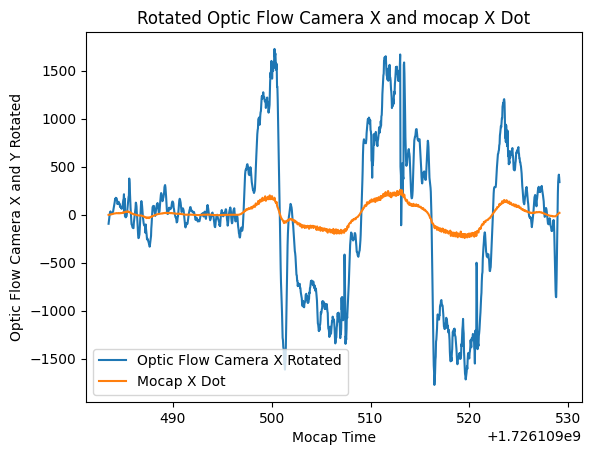

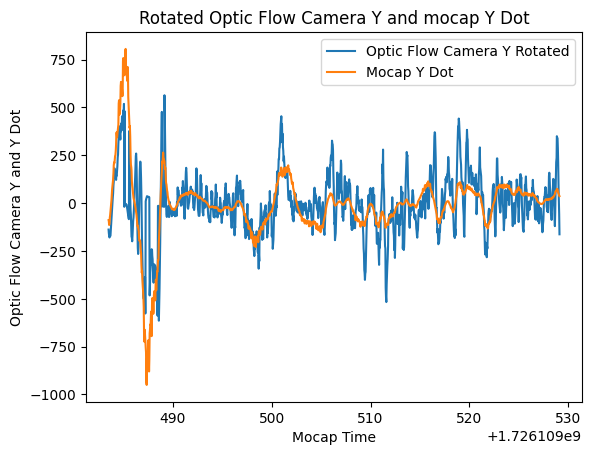

In [659]:
OFX=optic_flow_camera_x_mocap_interp
OFY=optic_flow_camera_y_mocap_interp
# apply a yaw rotation to the optic flow data using matrix multiplication
def rotate_optic_flow(OFX, OFY, Yaw):
    """
    input: OFX, OFY, Yaw
    output: rotated OFX, OFY
    """
    # apply a 180 degree rotation about x axis using the rotation matrix
    OFX = OFX*1
    OFY = OFY*np.cos(np.pi)

    # un yawing and rotating by 90 degrees
    OFY_rot = np.sin(Yaw+np.pi/2) * OFX + np.cos(Yaw+np.pi/2) * OFY
    OFX_rot = np.cos(Yaw+np.pi/2) * OFX - np.sin(Yaw+np.pi/2) * OFY
    return OFX_rot, OFY_rot


OFX_rot, OFY_rot = rotate_optic_flow(OFX, OFY, np.radians(mocap_Yaw))

# Plot the rotated optic flow data
plt.plot(mocap_time, np.multiply(OFX_rot,1), label="Optic Flow Camera X Rotated")
plt.plot(mocap_time,np.multiply(mocap_X_dot,100), label="Mocap X Dot")
# plt.plot(mocap_time, OFY_rot, label="Optic Flow Camera Y Rotated")
plt.title('Rotated Optic Flow Camera X and mocap X Dot')
plt.xlabel('Mocap Time')
plt.ylabel('Optic Flow Camera X and Y Rotated')
plt.legend()
plt.show()

plt.plot(mocap_time, np.multiply(OFY_rot,1), label="Optic Flow Camera Y Rotated")
plt.plot(mocap_time,np.multiply(mocap_Y_dot,1000), label="Mocap Y Dot")
plt.title('Rotated Optic Flow Camera Y and mocap Y Dot')
plt.xlabel('Mocap Time')
plt.ylabel('Optic Flow Camera Y and Y Dot')
plt.legend()
plt.show()



1371
Scalar (meters/pixel) X: 0.0013612685328604028
Scalar (meters/pixel) Y: 0.0009878484782878815


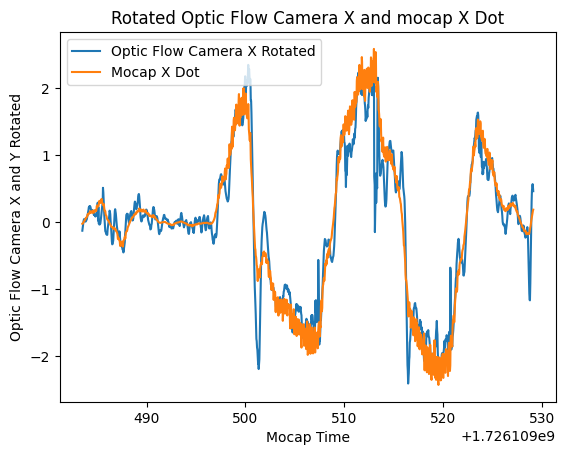

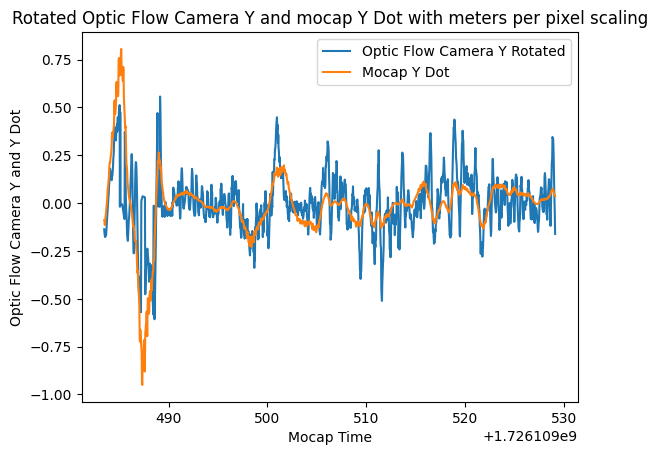

In [660]:
# Reshape the optic flow data to fit the linear regression model
OFX_rot_temp = np.array(OFX_rot).reshape(-1, 1)
OFY_rot_temp = np.array(OFY_rot)[:int(len(optic_flow_camera_x_mocap_interp)/4)].reshape(-1, 1)
print(len(OFY))
# Perform linear regression
modelX = LinearRegression()
modelX.fit(OFX_rot_temp, mocap_X_dot)

# The slope of the linear regression gives you the scalar (meters/pixel)
meters_per_pixel_X = modelX.coef_[0]

print(f"Scalar (meters/pixel) X: {meters_per_pixel_X}")

modelY = LinearRegression()
modelY.fit(OFY_rot_temp, mocap_Y_dot[:int(len(optic_flow_camera_x_mocap_interp)/4)])

# The slope of the linear regression gives you the scalar (meters/pixel)
meters_per_pixel_Y = modelY.coef_[0]

print(f"Scalar (meters/pixel) Y: {meters_per_pixel_Y}")

# Plot the rotated optic flow data
plt.plot(mocap_time, np.multiply(OFX_rot,meters_per_pixel_X), label="Optic Flow Camera X Rotated")
plt.plot(mocap_time,np.multiply(mocap_X_dot,1), label="Mocap X Dot")
# plt.plot(mocap_time, OFY_rot, label="Optic Flow Camera Y Rotated")
plt.title('Rotated Optic Flow Camera X and mocap X Dot')
plt.xlabel('Mocap Time')
plt.ylabel('Optic Flow Camera X and Y Rotated')
plt.legend()
plt.show()

plt.plot(mocap_time, np.multiply(OFY_rot,meters_per_pixel_Y), label="Optic Flow Camera Y Rotated")
plt.plot(mocap_time,np.multiply(mocap_Y_dot,1), label="Mocap Y Dot")
plt.title('Rotated Optic Flow Camera Y and mocap Y Dot with meters per pixel scaling')
plt.xlabel('Mocap Time')
plt.ylabel('Optic Flow Camera Y and Y Dot')
plt.legend()
plt.show()

## <center> Wind Sensor (Ultrasonic) <center>

In [661]:
data['trisonica']
# print columns of the trisonica data
for col in data['trisonica'].columns:
    print(col)

rosbagTimestamp
header
seq
stamp
secs
nsecs
frame_id
speed
speed2d
direction
northsouth
westeast
updown
temperature
pitch
roll
pressure
humidity
heading
levelx
levely
levelz


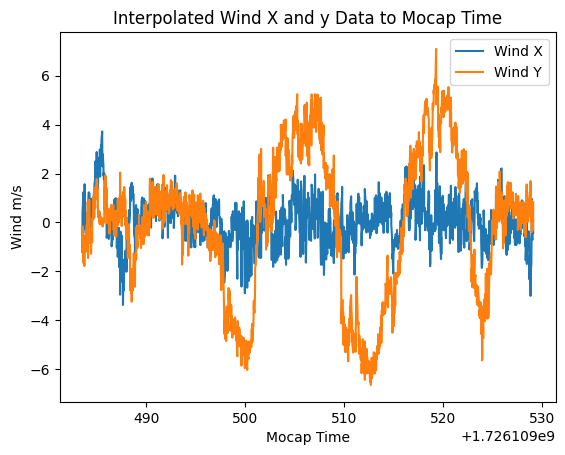

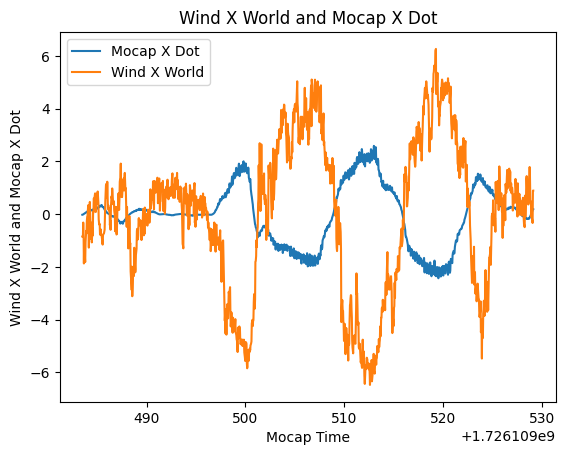

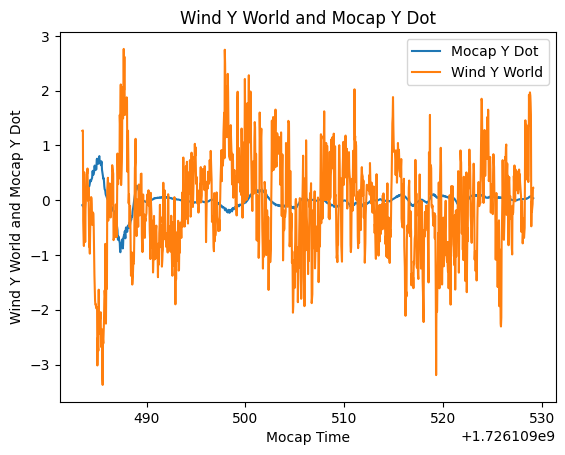

In [662]:
wind_time = data['trisonica']['rosbagTimestamp']/1e9
wind_x = data['trisonica']['westeast']
wind_y = -1*data['trisonica']['northsouth']

# interpolate wind data to mocap time
wind_x_mocap_interp = interpolate_data(wind_time, wind_x, mocap_time)
wind_y_mocap_interp = interpolate_data(wind_time, wind_y, mocap_time)

# Plot the interpolated data
plt.plot(wind_time, wind_x, label="Wind X")
plt.plot(wind_time, wind_y, label="Wind Y")
plt.title('Interpolated Wind X and y Data to Mocap Time')
plt.xlabel('Mocap Time')
plt.ylabel('Wind m/s')
plt.legend()
plt.show()



# bring the wind data to the global frame unpitch and unroll and unyaw
def rotate_wind_to_world_frame(wind_x, wind_y, roll, pitch, yaw):
    """
    Rotates the wind data from the body frame to the world frame.
    
    wind_x, wind_y: numpy arrays
        Arrays of wind velocity in the body frame along the x and y axes.
    roll, pitch, yaw: numpy arrays
        Arrays of roll, pitch, and yaw angles (in radians).
    
    Returns:
    wind_x_world, wind_y_world: numpy arrays
        Wind velocity in the world frame along the x and y axes.
    """
    # Initialize world-frame wind velocity arrays
    wind_x_world = np.zeros_like(wind_x)
    wind_y_world = np.zeros_like(wind_y)
    
    # Loop over each time step and rotate the wind velocity
    for i in range(len(wind_x)):
        # Get the rotation matrix for the current orientation (roll, pitch, yaw)
        R = rotation_matrix_from_euler(roll[i], pitch[i], yaw[i])
        
        # Measured wind velocity in body frame
        wind_body = np.array([wind_x[i], wind_y[i],0])
        
        # Rotate the body-frame wind velocity to the world frame
        wind_world = R @ wind_body
        
        # Store the world-frame wind velocity
        wind_x_world[i] = wind_world[0]
        wind_y_world[i] = wind_world[1]
    
    return wind_x_world, wind_y_world

# Rotate the wind data to the world frame
wind_x_world, wind_y_world = rotate_wind_to_world_frame(wind_x_mocap_interp, wind_y_mocap_interp, np.radians(mocap_Roll), np.radians(mocap_Pitch), np.radians(mocap_Yaw))

plt.plot(mocap_time, mocap_X_dot, label="Mocap X Dot")
plt.plot(mocap_time, wind_x_world, label="Wind X World")
plt.title('Wind X World and Mocap X Dot')
plt.xlabel('Mocap Time')
plt.ylabel('Wind X World and Mocap X Dot')
plt.legend()
plt.show()

plt.plot(mocap_time, mocap_Y_dot, label="Mocap Y Dot")
plt.plot(mocap_time, wind_y_world, label="Wind Y World")
plt.title('Wind Y World and Mocap Y Dot')
plt.xlabel('Mocap Time')
plt.ylabel('Wind Y World and Mocap Y Dot')
plt.legend()
plt.show()


Scalar (unitless) X: -0.3590088510163499
Scalar (unitless) Y: -0.2627441906754611


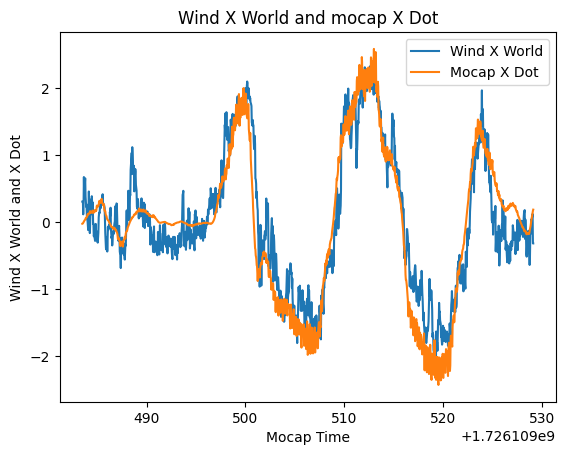

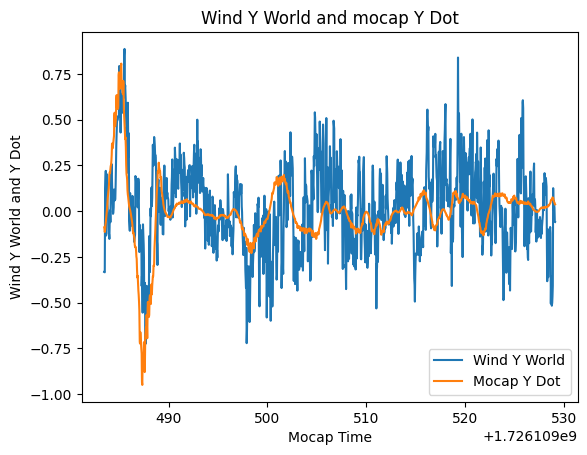

In [663]:
# Reshape the wind data to fit the linear regression model
wind_x_world_temp = np.array(wind_x_world).reshape(-1, 1)
wind_y_world_temp = np.array(wind_y_world)[:int(len(wind_x_world)/8)].reshape(-1, 1)

# Perform linear regression
modelX = LinearRegression()
modelX.fit(wind_x_world_temp, mocap_X_dot)

# The slope of the linear regression gives you the scalar unitless
Unit_X = modelX.coef_[0]

print(f"Scalar (unitless) X: {Unit_X}")

modelY = LinearRegression()
modelY.fit(wind_y_world_temp, mocap_Y_dot[:int(len(wind_x_world)/8)])

# The slope of the linear regression gives you the scalar unitless
Unit_Y = modelY.coef_[0]

print(f"Scalar (unitless) Y: {Unit_Y}")

# Plot the rotated wind data
plt.plot(mocap_time, np.multiply(wind_x_world,Unit_X), label="Wind X World")
plt.plot(mocap_time, mocap_X_dot, label="Mocap X Dot")
plt.title('Wind X World and mocap X Dot')
plt.xlabel('Mocap Time')
plt.ylabel('Wind X World and X Dot')
plt.legend()
plt.show()

plt.plot(mocap_time, np.multiply(wind_y_world,Unit_Y), label="Wind Y World")
plt.plot(mocap_time, mocap_Y_dot, label="Mocap Y Dot")
plt.title('Wind Y World and mocap Y Dot')
plt.xlabel('Mocap Time')
plt.ylabel('Wind Y World and Y Dot')
plt.legend()
plt.show()



# <center> RC Out ~ PWM <Center>

In [664]:
data['mavros/rc/out']
# split the data in header "channels" into individual columns named PWM1, PWM2, PWM3, PWM4 (only take the first 4 channels) each colum should be a float not a string
rc_time = data['mavros/rc/out']['rosbagTimestamp']/1e9
rc_channels = data['mavros/rc/out']['channels']
rc_channels = rc_channels.str.split(',', expand=True)
# remove "[" from the first column
rc_channels[0] = rc_channels[0].str.replace('[','')
rc_channels = rc_channels.iloc[:, :4]
rc_channels = rc_channels.astype(float)
PX4_1 = rc_channels[0]
PX4_2 = rc_channels[1]
PX4_3 = rc_channels[2]
PX4_4 = rc_channels[3]

## <center> Remap from PX4 motor layout to Dynamics motor layout <center>

<center>

PX4_1 ---> pwm_2 <br>
PX4_2 ---> pwm_4 <br>
PX4_3 ---> pwm_1 <br>
PX4_4 ---> pwm_3 <br>

<Center>

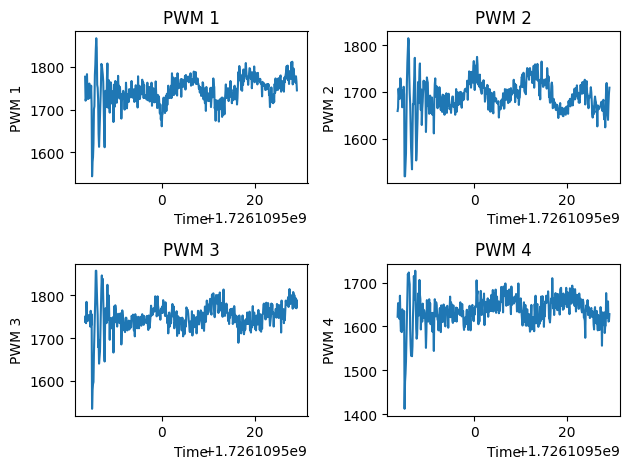

In [665]:
pwm_1 = PX4_3
pwm_2 = PX4_1
pwm_3 = PX4_4
pwm_4 = PX4_2
# 2x2 plot of the pwm data
plt.subplot(2, 2, 1)
plt.plot(rc_time, pwm_1)
plt.title('PWM 1')
plt.xlabel('Time')
plt.ylabel('PWM 1')

plt.subplot(2, 2, 2)
plt.plot(rc_time, pwm_2)
plt.title('PWM 2')
plt.xlabel('Time')
plt.ylabel('PWM 2')

plt.subplot(2, 2, 3)
plt.plot(rc_time, pwm_3)
plt.title('PWM 3')
plt.xlabel('Time')
plt.ylabel('PWM 3')

plt.subplot(2, 2, 4)
plt.plot(rc_time, pwm_4)
plt.title('PWM 4')
plt.xlabel('Time')
plt.ylabel('PWM 4')

plt.tight_layout()
plt.show()

In [747]:
print('pwm_1:', np.min(pwm_1),'pmw_2:', np.min(pwm_2),'pwm_3:', np.min(pwm_3),'pwm_4:', np.min(pwm_4))

pwm_1: 1544.0 pmw_2: 1519.0 pwm_3: 1534.0 pwm_4: 1412.0


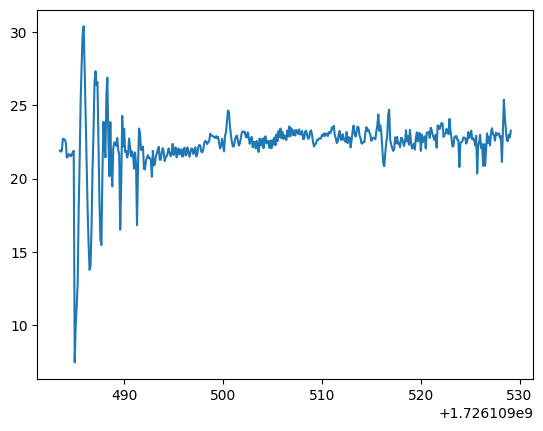

In [750]:
Real_b   = 1.8311
BIGU=((pwm_1-1400)+(pwm_2-1400)+(pwm_3-1400)+(pwm_4-1400))*Real_b/100
plt.plot(rc_time, BIGU)

# <center> Get the final values for all measuered data <center>

## <center> Since Optic Flow is the fastes we will interpolate to that <center>

### <center> Mocap Final <center>

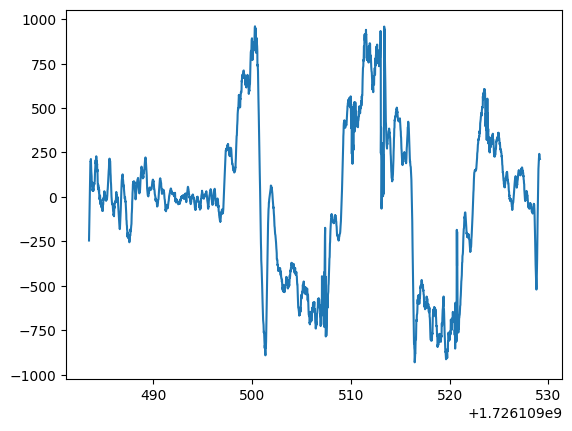

In [666]:
X_TRUE = interpolate_data(mocap_time, mocap_X, optic_flow_camera_x_time)
plt.plot(optic_flow_camera_x_time, optic_flow_camera_x)
X_DOT_TRUE = interpolate_data(mocap_time, mocap_X_dot, optic_flow_camera_x_time)
Y_TRUE = interpolate_data(mocap_time, mocap_Y, optic_flow_camera_x_time)
Y_DOT_TRUE = interpolate_data(mocap_time, mocap_Y_dot, optic_flow_camera_x_time)
Z_TRUE = interpolate_data(mocap_time, mocap_Z, optic_flow_camera_x_time)
Z_DOT_TRUE = interpolate_data(mocap_time, mocap_Z_dot, optic_flow_camera_x_time)
ROLL_TRUE = np.radians(interpolate_data(mocap_time, mocap_Roll, optic_flow_camera_x_time))
PITCH_TRUE = np.radians(interpolate_data(mocap_time, mocap_Pitch, optic_flow_camera_x_time))
YAW_TRUE = np.radians(interpolate_data(mocap_time, mocap_Yaw, optic_flow_camera_x_time))



### <center> IMU Final <center>

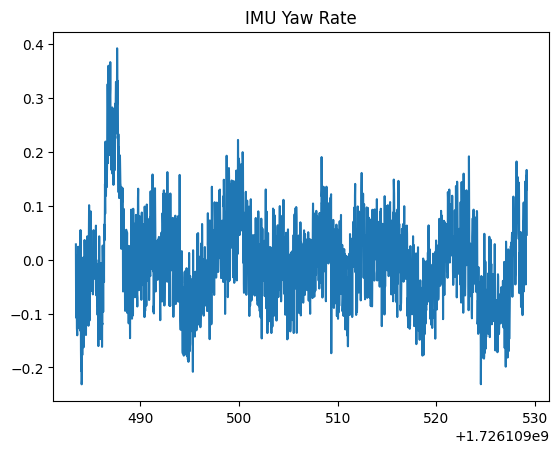

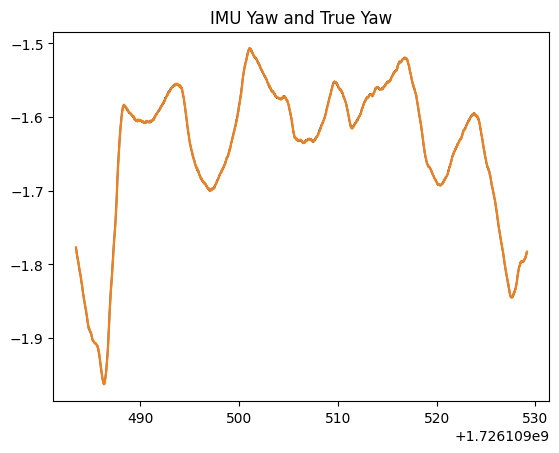

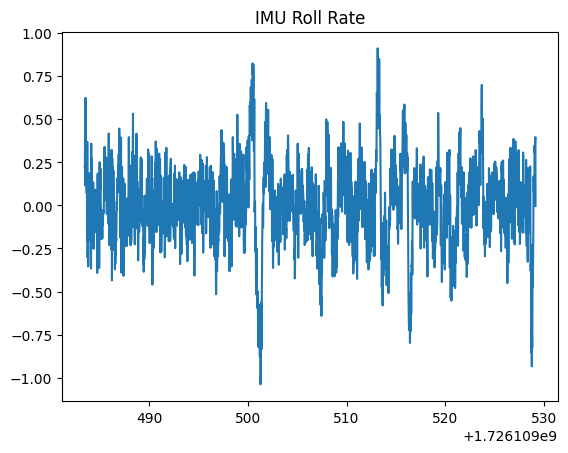

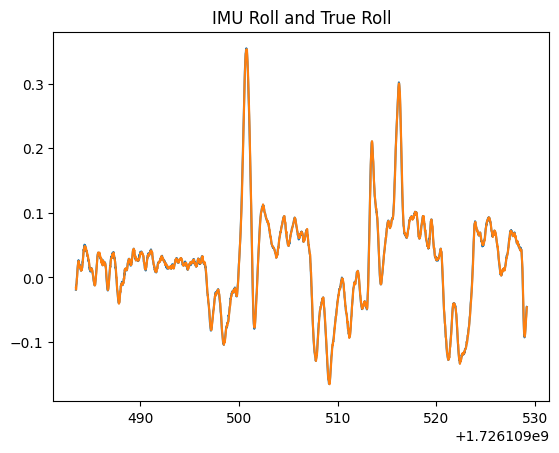

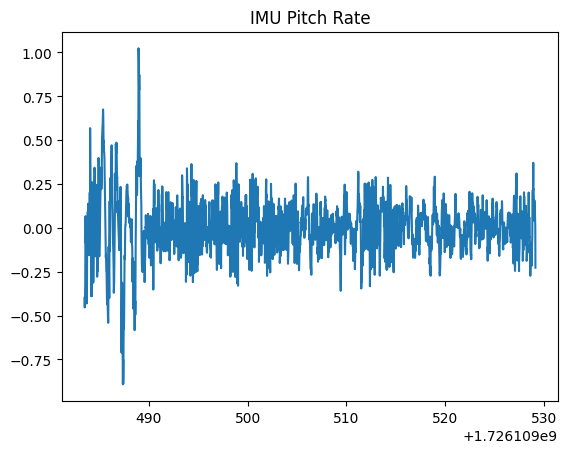

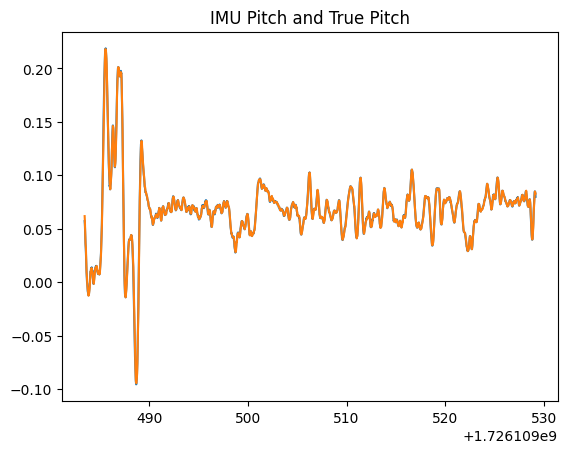

In [794]:
IMU_ROLL = interpolate_data(imu_time, imu_Roll, optic_flow_camera_x_time)
IMU_PITCH = interpolate_data(imu_time, imu_Pitch, optic_flow_camera_x_time)
IMU_YAW = interpolate_data(imu_time, imu_Yaw, optic_flow_camera_x_time)
IMU_ROLL_RATE = interpolate_data(imu_time, imu_Roll_rate, optic_flow_camera_x_time)
IMU_PITCH_RATE = interpolate_data(imu_time, imu_Pitch_rate, optic_flow_camera_x_time)
IMU_YAW_RATE = interpolate_data(imu_time, imu_Yaw_rate, optic_flow_camera_x_time)
IMU_ACC_X = interpolate_data(imu_time, imu_acc_x_corrected_world, optic_flow_camera_x_time)
IMU_ACC_Y = interpolate_data(imu_time, imu_acc_y_corrected_world, optic_flow_camera_x_time)
IMU_ACC_Z = interpolate_data(imu_time, imu_acc_z_corrected_world, optic_flow_camera_x_time)

plt.plot(optic_flow_camera_x_time, IMU_YAW_RATE)
plt.title('IMU Yaw Rate')
plt.show()

plt.plot(optic_flow_camera_x_time, IMU_YAW)
plt.plot(optic_flow_camera_x_time, YAW_TRUE)
plt.title('IMU Yaw and True Yaw')
plt.show()

plt.plot(optic_flow_camera_x_time, IMU_ROLL_RATE)
plt.title('IMU Roll Rate')
plt.show()

plt.plot(optic_flow_camera_x_time, IMU_ROLL)
plt.plot(optic_flow_camera_x_time, ROLL_TRUE)
plt.title('IMU Roll and True Roll')
plt.show()

plt.plot(optic_flow_camera_x_time, IMU_PITCH_RATE)
plt.title('IMU Pitch Rate')
plt.show()

plt.plot(optic_flow_camera_x_time, IMU_PITCH)
plt.plot(optic_flow_camera_x_time, PITCH_TRUE)
plt.title('IMU Pitch and True Pitch')
plt.show()


### <center> Wind Sensor Final <center>

In [668]:
WIND_X = interpolate_data(mocap_time, wind_x_world, optic_flow_camera_x_time)
WIND_Y = interpolate_data(mocap_time, wind_y_world, optic_flow_camera_x_time)
WIND_X_f = 1*Unit_X
WIND_Y_f = 1*Unit_Y
WIND_Z_f = 1

### <center> Optic Flow <center>

In [669]:
OF_X, OF_Y = rotate_optic_flow(optic_flow_camera_x, optic_flow_camera_y, IMU_YAW)
OF_X_f=1*meters_per_pixel_X
OF_Y_f=1*meters_per_pixel_Y
OF_Z_f=1

### <center> PWM Final <center>

In [751]:
PWM_1 = (interpolate_data(rc_time, pwm_1, optic_flow_camera_x_time)-1400)/100
PWM_2 = (interpolate_data(rc_time, pwm_2, optic_flow_camera_x_time)-1400)/100
PWM_3 = (interpolate_data(rc_time, pwm_3, optic_flow_camera_x_time)-1400)/100
PWM_4 = (interpolate_data(rc_time, pwm_4, optic_flow_camera_x_time)-1400)/100

### <center> Time <center>

In [752]:
TIME = optic_flow_camera_x_time-optic_flow_camera_x_time[0]
DT=TIME[1]-TIME[0]


### <center> Double checking <center>

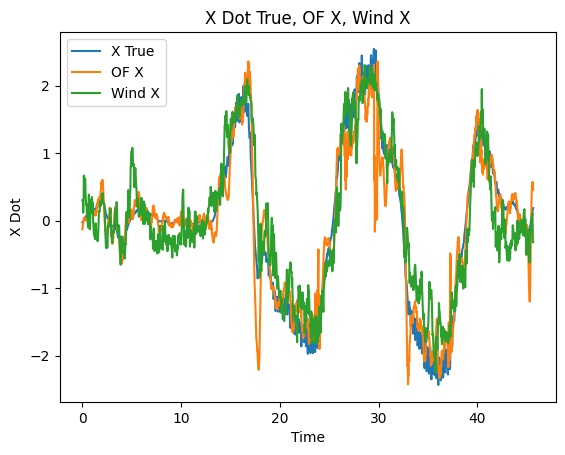

In [753]:
# plot mocap x and optic flow x and wind x
plt.plot(TIME, X_DOT_TRUE, label="X True")
# vx=of_x*of_x_f*z
plt.plot(TIME, np.multiply(np.multiply(OF_X,OF_X_f),Z_TRUE), label="OF X")
plt.plot(TIME, np.multiply(WIND_X,WIND_X_f), label="Wind X")
plt.title('X Dot True, OF X, Wind X')
plt.xlabel('Time')
plt.ylabel('X Dot')
plt.legend()


# <center> Real Drone Parameters <center>

In [754]:
########################################################################################
#################### Real Drone Parameters #############################################
########################################################################################
Real_m   = 0.086  # [kg] mass
Real_M   = 2.529  # [kg] mass
Real_mM  = Real_M+4*Real_m  # [kg] mass (total=2.529+4*0.086=2.897)
Real_l   = 0.2032 # [m] length
Real_r   = 0.1778 # [m] average body radius
Real_Ix  = 2*(Real_M*Real_r**2)/5 + 2*Real_m*Real_l**2 # [kg*m^2] moment of inertia
Real_Iy  = 2*(Real_M*Real_r**2)/5 + 2*Real_m*Real_l**2 # [kg*m^2] moment of inertia
Real_Iz  = 2*(Real_M*Real_r**2)/5 + 4*Real_m*Real_l**2 # [kg*m^2] moment of inertia
Real_Jr  = 2*(Real_M*Real_r**2)/5 # [kg*m^2] polar moment of inertia ### FAKE VALUE
Real_b   = 1.8311 # thrust coefficient
Real_d   = 0.01 # drag coefficient
Real_Dl  = 0.1 # drag coefficient from ground speed plus air speed
Real_Dr  = 0.1 # drag coefficient from rotation speed

print('Real Drone Parameters:')
print('Real_m:       ', Real_m)
print('Real_M:       ', Real_M)
print('Real_M_total: ', Real_mM)
print('Real_l:       ', Real_l)
print('Real_r:       ', Real_r)
print('Real_Ix:      ', Real_Ix)
print('Real_Iy:      ', Real_Iy)
print('Real_Iz:      ', Real_Iz)
print('Real_Jr:      ', Real_Jr)
print('Real_b:       ', Real_b)
print('Real_d:       ', Real_d)
print('Real_Dl:      ', Real_Dl)
print('Real_Dr:      ', Real_Dr)


# params = [m,l,Ix,Iy,Iz,Jr,b,d,Dl,Dr]
params = [Real_mM,Real_l,Real_Ix,Real_Iy,Real_Iz,Real_Jr,Real_b,Real_d,Real_Dl,Real_Dr]
g  = 9.81 # m/s^2

Real Drone Parameters:
Real_m:        0.086
Real_M:        2.529
Real_M_total:  2.8729999999999998
Real_l:        0.2032
Real_r:        0.1778
Real_Ix:       0.039081470224
Real_Iy:       0.039081470224
Real_Iz:       0.046183391504
Real_Jr:       0.031979548944
Real_b:        1.8311
Real_d:        0.01
Real_Dl:       0.1
Real_Dr:       0.1


In [755]:
def f_d(X, U):
    # Extract state variables
    x, vx, y, vy, z, vz, phi, dphi, theta, dtheta, psi, dpsi, wx, wy, wz = np.ravel(X)
    
    # Extract control inputs
    PWM1, PWM2, PWM3, PWM4 = np.ravel(U)
    
    # Compute intermediate variables
    U1 = Real_b * (PWM1 + PWM2 + PWM3 + PWM4)
    U2 = Real_b * (PWM4 + PWM1 - PWM2 - PWM3)
    U3 = Real_b * (PWM3 + PWM4 - PWM1 - PWM2)
    U4 = Real_d * (-PWM1 + PWM2 - PWM3 + PWM4)
    Omega = PWM2**(1/2) + PWM4**(1/2) - PWM1**(1/2) - PWM3**(1/2)

    # define drag dynamics
    vrx = vx + wx
    vry = vy + wy
    vrz = vz + wz
    dt=DT
    new_x=x + vx * dt
    new_vx = vx+(1/Real_mM) * (np.cos(phi) * np.sin(theta) * np.cos(psi) + np.sin(phi) * np.sin(psi)) * U1 - (Real_Dl * vrx / Real_mM) * dt
    new_y = y + vy * dt
    new_vy = vy+(1/Real_mM) * (np.cos(phi) * np.sin(theta) * np.sin(psi) - np.sin(phi) * np.cos(psi)) * U1 - (Real_Dl * vry / Real_mM) * dt
    new_z = z + vz * dt
    new_vz = vz+(1/Real_mM) * (np.cos(phi) * np.cos(theta)) * U1 - g - (Real_Dl * vrz / Real_mM) * dt
    new_phi = phi + dphi * dt
    new_dphi = dphi+dtheta * dpsi * (Real_Iy - Real_Iz) / Real_Ix - (Real_Jr * dtheta * Omega / Real_Ix) + (U2 * Real_l / Real_Ix) - (Real_Dr * dphi / Real_Ix) * dt
    new_theta = theta + dtheta * dt
    new_dtheta = dtheta+dphi * dpsi * (Real_Iz - Real_Ix) / Real_Iy + (Real_Jr * dphi * Omega / Real_Iy) + (U3 * Real_l / Real_Iy) - (Real_Dr * dtheta / Real_Iy) * dt
    new_psi = psi + dpsi * dt
    new_dpsi = dpsi+dphi * dtheta * (Real_Ix - Real_Iy) / Real_Iz + (U4 / Real_Iz) - (Real_Dr * dpsi / Real_Iz) * dt
    new_wx = 0
    new_wy = 0
    new_wz = 0
    
    new_X = np.atleast_2d(np.array([new_x, new_vx, new_y, new_vy, new_z, new_vz, new_phi, new_dphi, new_theta, new_dtheta, new_psi, new_dpsi,new_wx,new_wy,new_wz])).T

    return new_X

# write function as a continuous time function
def f_c(X, U):
    # Extract state variables
    x, vx, y, vy, z, vz, phi, dphi, theta, dtheta, psi, dpsi, wx, wy, wz = np.ravel(X)
    
    # Extract control inputs
    PWM1, PWM2, PWM3, PWM4 = np.ravel(U)
    
    # Compute intermediate variables
    U1 = Real_b * (PWM1 + PWM2 + PWM3 + PWM4)
    U2 = Real_b * (PWM4 + PWM1 - PWM2 - PWM3)
    U3 = Real_b * (PWM3 + PWM4 - PWM1 - PWM2)
    U4 = Real_d * (-PWM1 + PWM2 - PWM3 + PWM4)
    Omega = PWM2**(1/2) + PWM4**(1/2) - PWM1**(1/2) - PWM3**(1/2)

    # define drag dynamics
    vrx = vx + wx
    vry = vy + wy
    vrz = vz + wz
    dt=DT
    dxdt=vx
    dvxdt = (1/Real_mM) * (np.cos(phi) * np.sin(theta) * np.cos(psi) + np.sin(phi) * np.sin(psi)) * U1 - (Real_Dl * vrx / Real_mM)
    dydt=vy
    dvydt = (1/Real_mM) * (np.cos(phi) * np.sin(theta) * np.sin(psi) - np.sin(phi) * np.cos(psi)) * U1 - (Real_Dl * vry / Real_mM)
    dzdt=vz
    dvzdt = (1/Real_mM) * (np.cos(phi) * np.cos(theta)) * U1 - g - (Real_Dl * vrz / Real_mM)
    dphidt=dphi
    ddphidt = dtheta * dpsi * (Real_Iy - Real_Iz) / Real_Ix - (Real_Jr * dtheta * Omega / Real_Ix) + (U2 * Real_l / Real_Ix) - (Real_Dr * dphi / Real_Ix)
    dthetadt= dtheta
    ddthetadt = dphi * dpsi * (Real_Iz - Real_Ix) / Real_Iy + (Real_Jr * dphi * Omega / Real_Iy) + (U3 * Real_l / Real_Iy) - (Real_Dr * dtheta / Real_Iy)
    dpsidt= dpsi
    ddpsidt = dphi * dtheta * (Real_Ix - Real_Iy) / Real_Iz + (U4 / Real_Iz) - (Real_Dr * dpsi / Real_Iz)
    dwx = 0
    dwy = 0
    dwz = 0
    

    new_X= scipy.integrate.odeint(lambda X, t: [dxdt, dvxdt, dydt, dvydt, dzdt, dvzdt, dphidt, ddphidt, dthetadt, ddthetadt, dpsidt, ddpsidt, dwx, dwy, dwz], np.ravel(X), [0, dt])[-1]
    new_X = np.atleast_2d(new_X).T
    return new_X

def h_d(X,U):
    # Extract the states
    x, vx, y, vy, z, vz, phi, dphi, theta, dtheta, psi, dpsi, wx, wy, wz = np.ravel(X)

    PWM1, PWM2, PWM3, PWM4 = np.ravel(U)
    
    U1 = Real_b * (PWM1 + PWM2 + PWM3 + PWM4)
    U2 = Real_b * (PWM4 + PWM1 - PWM2 - PWM3)
    U3 = Real_b * (PWM3 + PWM4 - PWM1 - PWM2)
    U4 = Real_d * (-PWM1 + PWM2 - PWM3 + PWM4)
    Omega = PWM2**(1/2) + PWM4**(1/2) - PWM1**(1/2) - PWM3**(1/2)

    Px   = x
    Vx   = vx
    Py   = y
    Vy   = vy
    Pz   = z
    Vz   = vz
    R    = phi
    dR   = dphi
    P    = theta
    dP   = dtheta
    Yaw  = psi
    dYaw = dpsi
    Wx   = wx
    Wy   = wy
    Wz   = wz
    OFx  = (1/OF_X_f)*vx/z
    OFy  = (1/OF_Y_f)*vy/z
    OFz  = (1/OF_Z_f)*vz/z
    Ax   =(vx+wx)/ WIND_X_f
    Ay   =(vy+wy)/ WIND_Y_f
    Az   =(vz+wz)/ WIND_Z_f
    Accx = (1/Real_mM) * (np.cos(phi) * np.sin(theta) * np.cos(psi) + np.sin(phi) * np.sin(psi)) * U1 - (Real_Dl * Ax / Real_mM)
    Accy = (1/Real_mM) * (np.cos(phi) * np.sin(theta) * np.sin(psi) - np.sin(phi) * np.cos(psi)) * U1 - (Real_Dl * Ay / Real_mM)
    Accz = (1/Real_mM) * (np.cos(phi) * np.cos(theta)) * U1 - g - (Real_Dl * Az / Real_mM)

    # Create clusters
    P_cluster = np.array([Px, Py, Pz])
    V_cluster = np.array([Vx, Vy, Vz])
    Attitude_cluster = np.array([R, P, Yaw])
    dAttitude_cluster = np.array([dR, dP, dYaw])
    W_cluster = np.array([Wx, Wy, Wz])
    OF_cluster = np.array([OFx, OFy, OFz])
    OF_cluster_XY = np.array([OFx, OFy])
    A_cluster = np.array([Ax, Ay, Az])
    A_cluster_XY = np.array([Ax, Ay])
    Acc_cluster = np.array([Accx, Accy, Accz])

    # Y=np.vstack((P_cluster, V_cluster, Attitude_cluster, dAttitude_cluster, W_cluster, OF_cluster, A_cluster))
    Y=np.atleast_2d(np.hstack((Attitude_cluster, dAttitude_cluster, Acc_cluster, OF_cluster_XY, A_cluster_XY))).T

    # Y = np.concatenate((P_cluster, V_cluster, Attitude_cluster, dAttitude_cluster, W_cluster, OF_cluster, A_cluster))
    # Only return the measured states
    # Y=np.atleast_2d(np.array([Vx, Vy, Vz, dR, dP, dYaw, Wx, Wy, Wz])).T
    return Y



In [855]:
# Define Ynoisy
# B_range=int(len(X_TRUE)/4)
# E_range=int(3*len(X_TRUE)/4)
B_range=0
E_range=len(X_TRUE)

# creat noisy measurements clusters
P_cluster = np.array([X_TRUE[B_range:E_range], Y_TRUE[B_range:E_range], Z_TRUE[B_range:E_range]])
V_cluster = np.array([X_DOT_TRUE[B_range:E_range], Y_DOT_TRUE[B_range:E_range], Z_DOT_TRUE[B_range:E_range]])
Attitude_cluster = np.array([ROLL_TRUE[B_range:E_range], PITCH_TRUE[B_range:E_range], YAW_TRUE[B_range:E_range]])
dAttitude_cluster = np.array([IMU_ROLL_RATE[B_range:E_range], IMU_PITCH_RATE[B_range:E_range], IMU_YAW_RATE[B_range:E_range]])
IMU_acc_cluster = np.array([IMU_ACC_X[B_range:E_range], IMU_ACC_Y[B_range:E_range], IMU_ACC_Z[B_range:E_range]])
IMU_attitude_cluster = np.array([IMU_ROLL[B_range:E_range], IMU_PITCH[B_range:E_range], IMU_YAW[B_range:E_range]])
IMU_Dattitude_cluster = np.array([IMU_ROLL_RATE[B_range:E_range], IMU_PITCH_RATE[B_range:E_range], IMU_YAW_RATE[B_range:E_range]])
OF_cluster = np.array([OF_X[B_range:E_range], OF_Y[B_range:E_range]])
A_cluster = np.array([WIND_X[B_range:E_range], WIND_Y[B_range:E_range]])

Y_m = np.vstack((IMU_attitude_cluster, IMU_Dattitude_cluster, IMU_acc_cluster, OF_cluster, A_cluster))

U=np.vstack((PWM_1[B_range:E_range], PWM_2[B_range:E_range], PWM_3[B_range:E_range], PWM_4[B_range:E_range]))

# print('Ynoisy_small:',Ynoisy_small[0])

# Define the initial state estimate
# x0 = np.atleast_2d(X_MPC_noisy.T[0]).T
x0=np.atleast_2d(np.array([X_TRUE[B_range],X_DOT_TRUE[B_range],Y_TRUE[B_range],Y_DOT_TRUE[B_range],Z_TRUE[B_range],Z_DOT_TRUE[B_range],ROLL_TRUE[B_range],IMU_ROLL_RATE[B_range],PITCH_TRUE[B_range],IMU_PITCH_RATE[B_range],YAW_TRUE[B_range],IMU_YAW_RATE[B_range],WIND_X[B_range],WIND_Y[B_range],0.0])).T

# Define the process noise covariance matrix
Q = np.diag(np.array([0.0, 0.001, 0.0, 0.001, 0.0, 0.001, 0.0, 0.001, 0.0, 0.001, 0.0, 0.001, 0.001, 0.001, 0.001]))**2

# define the measurement noise covariance matrix based on clusters
IMU_attitudeV_cluster = np.array([0.01, 0.01, 0.01])
IMU_DattitudeV_cluster = np.array([0.1, 0.1, 0.1])
IMU_accV_cluster = np.array([0.1, 0.1, 0.1])
OFV_cluster = np.array([1, 1])
AV_cluster = np.array([0.05, 0.05])
v_small = np.hstack([IMU_attitudeV_cluster,IMU_DattitudeV_cluster,IMU_accV_cluster,OFV_cluster,AV_cluster])
R = np.power(np.diag(v_small),2)
P0 = np.diag(np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,0.1,0.1,0.1]))**2


In [856]:
# # plot each momponent of Y_m
# plt.plot(TIME[B_range:E_range], IMU_attitude_cluster[0], label="IMU Roll")
# plt.title('IMU Roll')
# plt.legend()
# plt.show()

# plt.plot(TIME[B_range:E_range], IMU_attitude_cluster[1], label="IMU Pitch")
# plt.title('IMU Pitch')
# plt.legend()
# plt.show()

# plt.plot(TIME[B_range:E_range], IMU_attitude_cluster[2], label="IMU Yaw")
# plt.title('IMU Yaw')
# plt.legend()
# plt.show()

# plt.plot(TIME[B_range:E_range], IMU_Dattitude_cluster[0], label="IMU Roll Rate")
# plt.title('IMU Roll Rate')
# plt.legend()
# plt.show()

# plt.plot(TIME[B_range:E_range], IMU_Dattitude_cluster[1], label="IMU Pitch Rate")
# plt.title('IMU Pitch Rate')
# plt.legend()
# plt.show()

# plt.plot(TIME[B_range:E_range], IMU_Dattitude_cluster[2], label="IMU Yaw Rate")
# plt.title('IMU Yaw Rate')
# plt.legend()
# plt.show()

# plt.plot(TIME[B_range:E_range], IMU_acc_cluster[0], label="IMU Acc X")
# plt.title('IMU Acc X')
# plt.legend()
# plt.show()

# plt.plot(TIME[B_range:E_range], IMU_acc_cluster[1], label="IMU Acc Y")
# plt.title('IMU Acc Y')
# plt.legend()
# plt.show()

# plt.plot(TIME[B_range:E_range], IMU_acc_cluster[2], label="IMU Acc Z")
# plt.title('IMU Acc Z')
# plt.legend()
# plt.show()

# plt.plot(TIME[B_range:E_range], OF_cluster[0], label="OF X")
# plt.title('OF X')
# plt.legend()
# plt.show()

# plt.plot(TIME[B_range:E_range], OF_cluster[1], label="OF Y")
# plt.title('OF Y')
# plt.legend()
# plt.show()

# plt.plot(TIME[B_range:E_range], A_cluster[0], label="Wind X")
# plt.title('Wind X')
# plt.legend()
# plt.show()

# plt.plot(TIME[B_range:E_range], A_cluster[1], label="Wind Y")
# plt.title('Wind Y')
# plt.legend()
# plt.show()


In [857]:
# check that all inputs are a two-dimensional array
print('Ynoisy_small:',Y_m.shape)
print('x0:',x0.shape)
print('U:',U.shape)
print('Q:',Q.shape)
print('R:',R.shape)
print('P0:',P0.shape)
print('v_small:',v_small)


Ynoisy_small: (13, 2720)
x0: (15, 1)
U: (4, 2720)
Q: (15, 15)
R: (13, 13)
P0: (15, 15)
v_small: [0.01 0.01 0.01 0.1  0.1  0.1  0.1  0.1  0.1  1.   1.   0.05 0.05]


In [858]:
print(DT)

0.00941014289855957


In [859]:
xhat, P, s = EKF.ekf(Y_m, x0, f_c, h_d, Q, R, U, P0)

In [860]:
x_hat=xhat[0,:] # x estimate
vx_hat=xhat[1,:] # vx estimate
y_hat=xhat[2,:] # y estimate
vy_hat=xhat[3,:] # vy estimate
z_hat=xhat[4,:] # z estimate
vz_hat=xhat[5,:] # vz estimate
phi_hat=xhat[6,:] # phi estimate
dphi_hat=xhat[7,:] # dphi estimate
theta_hat=xhat[8,:] # theta estimate
dtheta_hat=xhat[9,:] # dtheta estimate
psi_hat=xhat[10,:] # psi estimate
dpsi_hat=xhat[11,:] # dpsi estimate
wx_hat=xhat[12,:] # wx estimate
wy_hat=xhat[13,:] # wy estimate
wz_hat=xhat[14,:] # wz estimate


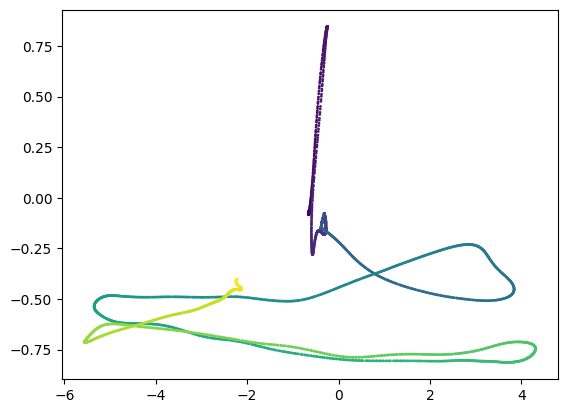

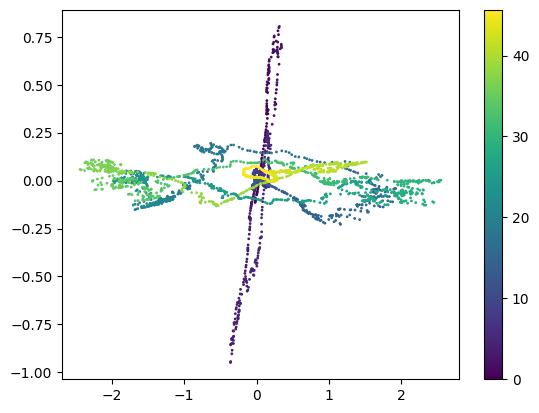

In [861]:
# plot 2d position
plt.scatter(X_TRUE,Y_TRUE,label='Estimated',s=1,c=TIME)
plt.show()

plt.scatter(X_DOT_TRUE,Y_DOT_TRUE,label='Estimated',s=1,c=TIME)
# add color bar for time
plt.colorbar()
plt.show()

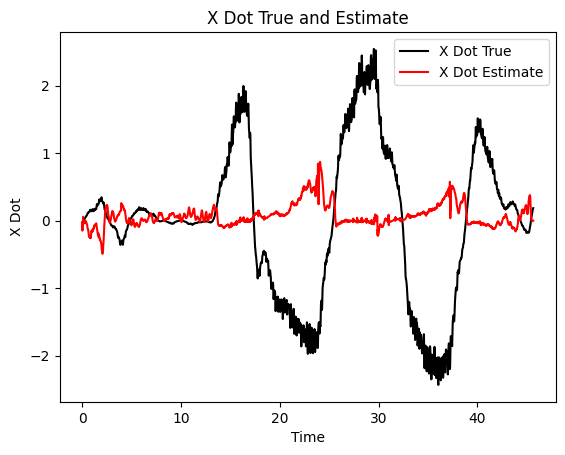

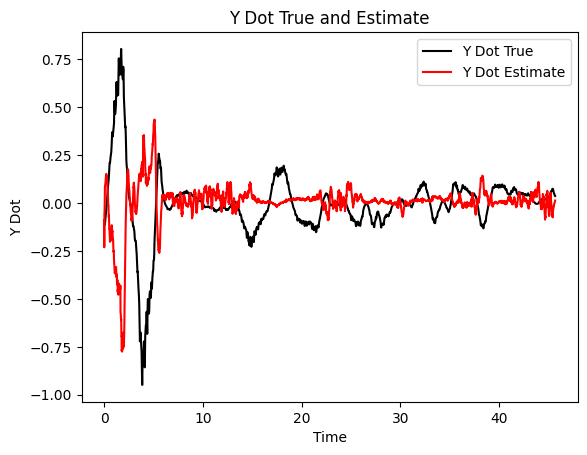

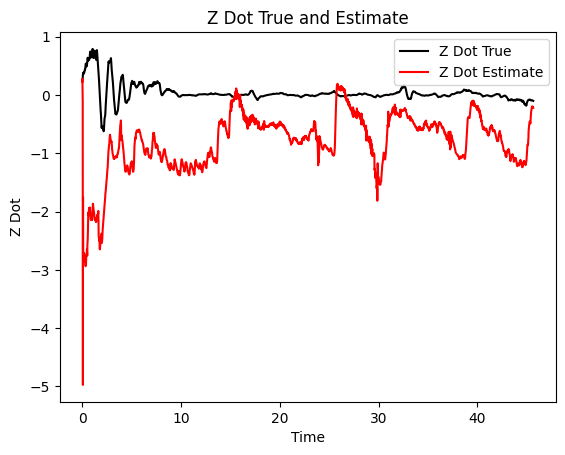

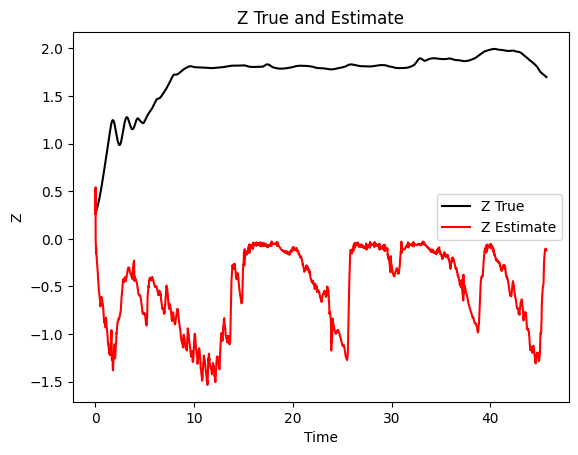

In [862]:
# plot estimate and true values for Vx, Vy, Vz
plt.plot(TIME, X_DOT_TRUE, label="X Dot True",color='black')
plt.plot(TIME[B_range:E_range], vx_hat, label="X Dot Estimate",color='red')
plt.title('X Dot True and Estimate')
plt.xlabel('Time')
plt.ylabel('X Dot')
plt.legend()
# plt.xlim([0,2])
# plt.ylim([-2,2])
plt.show()

plt.plot(TIME, Y_DOT_TRUE, label="Y Dot True",color='black')
plt.plot(TIME[B_range:E_range], vy_hat, label="Y Dot Estimate",color='red')
plt.title('Y Dot True and Estimate')
plt.xlabel('Time')
plt.ylabel('Y Dot')
plt.legend()
# plt.xlim([0,2])
# plt.ylim([-2,2])
plt.show()

plt.plot(TIME, Z_DOT_TRUE, label="Z Dot True",color='black')
plt.plot(TIME[B_range:E_range], vz_hat, label="Z Dot Estimate",color='red')
plt.title('Z Dot True and Estimate')
plt.xlabel('Time')
plt.ylabel('Z Dot')
plt.legend()
# plt.xlim([0,2])
# plt.ylim([-2,2])
plt.show()

plt.plot(TIME,Z_TRUE,label='Z True',color='black')
plt.plot(TIME[B_range:E_range],z_hat,label='Z Estimate',color='red')
plt.title('Z True and Estimate')
plt.xlabel('Time')
plt.ylabel('Z')
plt.legend()
# plt.xlim([0,2])
# plt.ylim([-2,2])
plt.show()




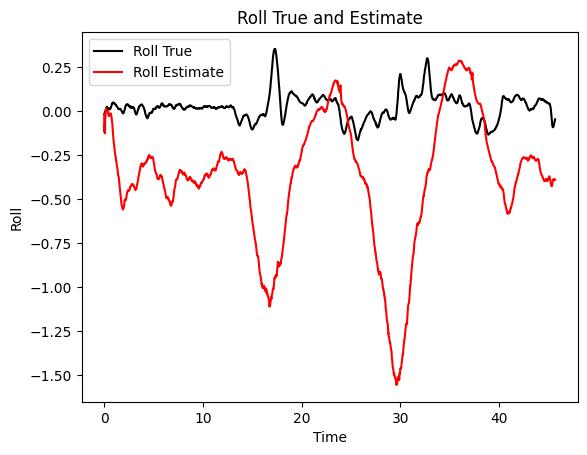

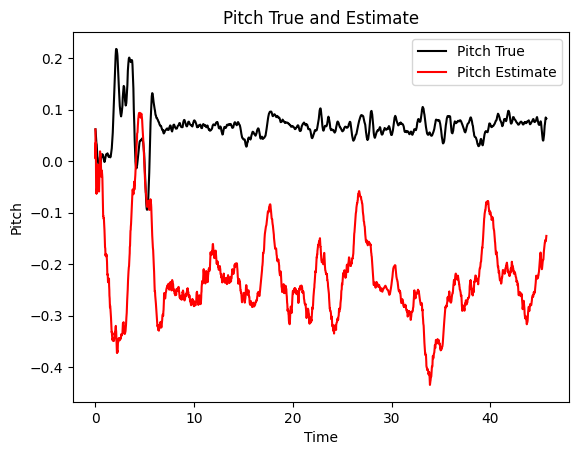

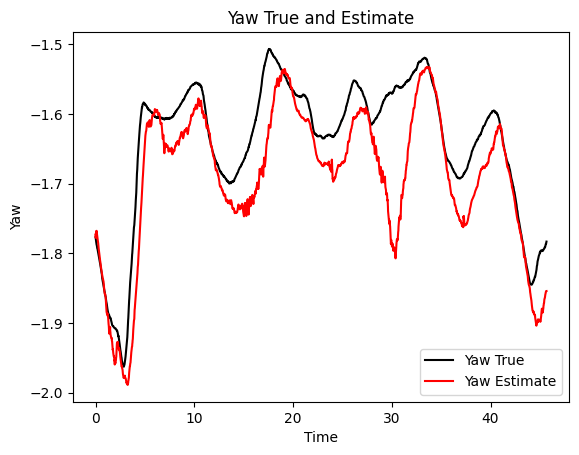

In [863]:
# plot the attitude real vs the attitude estimate
plt.plot(TIME,ROLL_TRUE,label='Roll True',color='black')
plt.plot(TIME[B_range:E_range],phi_hat,label='Roll Estimate',color='red')
plt.title('Roll True and Estimate')
plt.xlabel('Time')
plt.ylabel('Roll')
plt.legend()
# plt.xlim([0,1])
# plt.ylim([-2,2])
plt.show()

plt.plot(TIME,PITCH_TRUE,label='Pitch True',color='black')
plt.plot(TIME[B_range:E_range],theta_hat,label='Pitch Estimate',color='red')
plt.title('Pitch True and Estimate')
plt.xlabel('Time')
plt.ylabel('Pitch')
plt.legend()
# plt.xlim([0,1])
# plt.ylim([-3.14,3.14])
plt.show()

plt.plot(TIME,YAW_TRUE,label='Yaw True',color='black')
plt.plot(TIME[B_range:E_range],psi_hat,label='Yaw Estimate',color='red')
plt.title('Yaw True and Estimate')
plt.xlabel('Time')
plt.ylabel('Yaw')
plt.legend()
# plt.xlim([0,.1])
# plt.ylim([-2,2])
plt.show()  